In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100, load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from utils import train_valid_split

- MIA attack 할 때에는 attack net 이 10,000개의 cifar100 training data 만 사용
- 아래 cifar100 데이터로 나중에 attack net 학습 시에 사용했던 부분과 사용 안했던 부분을 나누어야 하기 때문에 stealloader 에서 일부 데이터만 사용
- MIA attack 을 위해서 cifar100의 attack net 학습 시에 사용했던 데이터와 사용하지 않은 validation data 를 저장해 두어야 함!

In [7]:
# load dataloader for steal
stealloader,st_testloader = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200",
                                   batch_size=128, train_shuffle=True)

# Steal Model 

## Attack comb net

- CombNet 에서 tau 설정 필요
- nb_stolen 으로 steal 시에 사용할 데이터 수 정할 수 있음

In [9]:
class args:
    save_dir = "../results"
#     orig_model = "cifar_orig_taylor.pth"
    orig_model = "cifar_orig_logit.pth"
#     fake_model = "cifar_fake_random_net.pth"
#     fake_model = "cifar_fake_taylor_ML.pth"
    fake_model = "cifar_fake_logit_ML_swd.pth"
    tau = 0.6
    nb_stolen = 10000 # attack model 학습시 사용할 데이터 수
#     st_trloader = "attnet_trloader.dl"
#     st_valloader = "attnet_valloader.dl"
#     att_epochs = 300
#     att_model = "cifar_attacknet_logit_ml_tau%.1f.pth"%(tau)
    att_model = "cifar_attacknet_logit_ml_swd_tau%.1f.pth"%(tau)

In [10]:
args.att_model

'cifar_attacknet_logit_ml_swd_tau0.6.pth'

In [11]:
from cifar_models import Net, Net_logit, AttackNet
from utils import CombNet, CombNet_logit,Net_softmax

In [12]:
import os
net = AttackNet()
net.load_state_dict(torch.load(os.path.join(args.save_dir,args.orig_model),map_location='cpu'))
net = Net_softmax(net)

net_fake = AttackNet()
net_fake.load_state_dict(torch.load(os.path.join(args.save_dir,args.fake_model),map_location='cpu'))
net_fake = Net_softmax(net_fake)

comb_net = CombNet(net, net_fake, args.tau)

In [13]:
st_trloader, st_valloader = train_valid_split(stealloader,args.nb_stolen*2)
# torch.save(st_trloader, os.path.join(args.save_dir,args.st_trloader))
# torch.save(st_valloader, os.path.join(args.save_dir,args.st_valloader))

total data: 20000


In [15]:
from utils import prepare_MIAattack_loader

In [16]:
mia_trloader = prepare_MIAattack_loader(comb_net, trainloader, st_trloader, device)
mia_teloader = prepare_MIAattack_loader(comb_net, testloader, st_teloader, device)

RuntimeError: Class values must be smaller than num_classes.

In [271]:
import copy
tr_accs_swd = copy.copy(tr_accs)
te_accs_swd = copy.copy(te_accs)

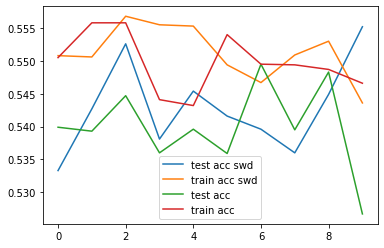

In [281]:
import matplotlib.pyplot as plt
plt.plot(te_accs_swd,label="test acc swd")
plt.plot(tr_accs_swd, label = "train acc swd")
plt.plot(te_accs,label="test acc")
plt.plot(tr_accs, label = "train acc")
plt.legend()
plt.show()

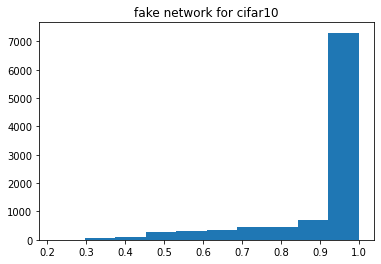

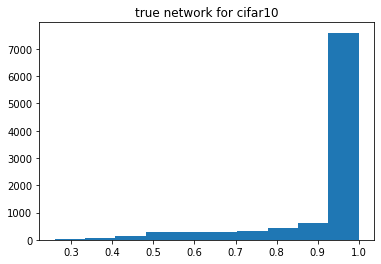

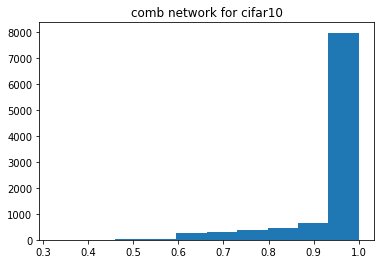

In [241]:
from utils import maxclass_hist, prediction_hist
# comb_net = CombNet_logit(net, net_fake, tau=0.99)
maxclass_hist(testloader, net_fake, device, plt_title="fake network for cifar10",
              clipping=True, clip_vals=[None,1000])
# maxclass_hist(testloader, net, device, plt_title="logit network for cifar10",
#               clipping=True, clip_vals=[None,1000])
maxclass_hist(testloader, net, device, plt_title="true network for cifar10",
              clipping=True, clip_vals=[None,1000])
maxclass_hist(testloader, comb_net, device, plt_title="comb network for cifar10",
              clipping=True, clip_vals=[None,1000])

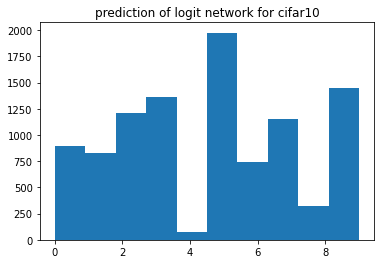

In [242]:
prediction_hist(testloader, net_fake, device, plt_title="prediction of logit network for cifar10")

In [14]:
att_net = AttackNet()
att_net.load_state_dict(torch.load(os.path.join(args.save_dir, args.att_model),map_location='cpu'))

<All keys matched successfully>

## test steal model

In [15]:
from utils import test_corr_model, Net_softmax, test_model
# att_net_prob = Net_softmax(att_net)
att_net_prob = Net_softmax(att_net)

In [16]:

criterion_att = nn.CrossEntropyLoss()
loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net_prob, testloader, criterion_att, device)

Accuracy/Loss 1: 81.90/1.6509
Accuracy/Loss 2: 65.62/1.9149
Correspondence:  tensor(65.7900)


In [17]:
test_model(net, testloader, criterion_att, device,100.0)

(tensor(1.6270), tensor(84.2900))

In [ ]:
st_teloader1, st_teloader2 = train_valid_split(st_testloader, total_data=10000, ratio=0.5) 

# Test MIA from att_net

## mia dataloader

In [18]:
from utils import train_valid_split

In [19]:
ori_trloader1,ori_trloader2 = train_valid_split(trainloader, total_data=10000, ratio=0.5) 
ori_teloader1, ori_teloader2 = train_valid_split(testloader, total_data=10000, ratio=0.5) 


total data: 10000
total data: 10000
total data: 10000


In [21]:
from utils import prepare_MIAattack_loader

- prepare_MIAattack_loader 에서 인자는 차례대로 학습에 사용한 network, 학습에 사용한 데이터, 학습에 사용하지 않은 데이터 에 해당한다!

In [22]:
# mia_trloader = prepare_MIAattack_loader(comb_net, ori_trloader1, ori_teloader1, device)
# mia_teloader = prepare_MIAattack_loader(comb_net, ori_trloader2, ori_teloader2, device)
mia_trloader = prepare_MIAattack_loader(att_net_prob, ori_trloader1, ori_teloader1, device)
mia_teloader = prepare_MIAattack_loader(att_net_prob, ori_trloader2, ori_teloader2, device)

data shape: torch.Size([10000, 20])
number of data for training and valid: 5000 5000
data shape: torch.Size([10000, 20])
number of data for training and valid: 5000 5000


## train mia attack model

In [23]:
from mia.estimators import AttackModelBundle
NUM_CLASSES=10

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.
    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [25]:
def run_mia_attack(comb_net, train_loader, test_loader):
    ori_trloader1,ori_trloader2 = train_valid_split(train_loader, total_data=10000, ratio=0.5) 
    ori_teloader1, ori_teloader2 = train_valid_split(test_loader, total_data=10000, ratio=0.5) 
    mia_trloader = prepare_MIAattack_loader(comb_net, ori_trloader1, ori_teloader1, device)

    X_shadow,y_shadow = mia_trloader.dataset.tensors[0].numpy(),mia_trloader.dataset.tensors[1].numpy()
    amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)
    amb.fit(X_shadow, y_shadow)
    tr_acc = np.mean(amb.predict(X_shadow)==y_shadow)
    print("training accuracy",tr_acc)
    
    mia_teloader = prepare_MIAattack_loader(comb_net, ori_trloader2, ori_teloader2, device)
    X_shadow_te,y_shadow_te = mia_teloader.dataset.tensors[0].numpy(),mia_teloader.dataset.tensors[1].numpy()
    te_acc = np.mean(amb.predict(X_shadow_te)==y_shadow_te)
    print("test accuracy:",te_acc)
    return amb, tr_acc, te_acc

In [26]:
X_shadow,y_shadow = mia_trloader.dataset.tensors[0].numpy(),mia_trloader.dataset.tensors[1].numpy()
X_shadow_te,y_shadow_te = mia_teloader.dataset.tensors[0].numpy(),mia_teloader.dataset.tensors[1].numpy()

In [27]:
print(X_shadow.shape, y_shadow.shape)
print(X_shadow[0])

(10000, 20) (10000,)
[0.00837009 0.07466025 0.00584845 0.4925688  0.02230073 0.11616462
 0.12224147 0.0121015  0.00153571 0.14420842 0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.        ]


In [28]:
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

In [29]:
amb.fit(X_shadow, y_shadow)

31/31 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5010


In [30]:
import numpy as np
np.mean(amb.predict(X_shadow_te)==y_shadow_te)

0.4933

In [21]:
from cifar_models import Net_MIA

In [22]:
from utils import test_model, AverageVarMeter, train_mia_model

In [28]:
mia_trloader.dataset.tensors

(tensor([[6.2552e-03, 5.2083e-01, 7.8346e-03,  ..., 0.0000e+00, 1.0000e+00,
          0.0000e+00],
         [2.1291e-02, 8.1158e-02, 1.6784e-02,  ..., 1.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.3101e-02, 6.7192e-04, 4.2825e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [9.2651e-03, 1.2185e-01, 6.0885e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0157e-02, 3.9354e-01, 1.4410e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.2844e-01, 1.3178e-02, 4.1829e-02,  ..., 0.0000e+00, 1.0000e+00,
          0.0000e+00]]),
 tensor([1., 1., 1.,  ..., 0., 0., 0.]))

In [23]:
mia_att_net = Net_MIA()

In [26]:
mia_criterion = nn.BCELoss()
mia_optimizer = optim.Adam(mia_att_net.parameters())
mia_epochs = 100

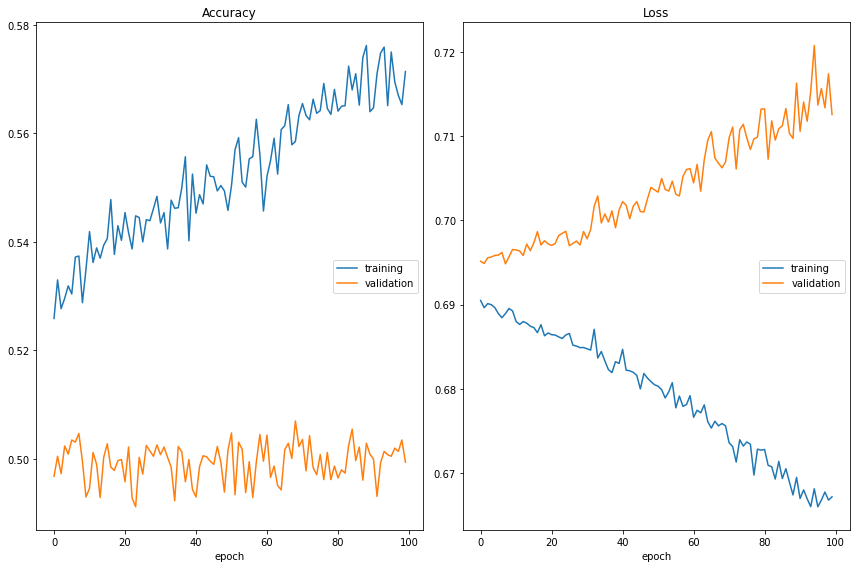

Accuracy
	training         	 (min:    0.526, max:    0.576, cur:    0.571)
	validation       	 (min:    0.491, max:    0.507, cur:    0.499)
Loss
	training         	 (min:    0.666, max:    0.690, cur:    0.667)
	validation       	 (min:    0.695, max:    0.721, cur:    0.713)


(Net_MIA(
   (lin1): Linear(in_features=20, out_features=128, bias=True)
   (lin2): Linear(in_features=128, out_features=64, bias=True)
   (lin3): Linear(in_features=64, out_features=64, bias=True)
   (lin4): Linear(in_features=64, out_features=1, bias=True)
 ),
 {'loss': 0.6671925783157349,
  'acc': 0.5714,
  'val_loss': 0.7125716209411621,
  'val_acc': 0.4994})

In [27]:
train_mia_model(mia_att_net, att_net, mia_trloader, mia_criterion, mia_optimizer, 
                 mia_epochs, device, mia_testloader = mia_teloader, 
                save_dir = "../results", save_model = "cifar_mia_model.pth")

## Test MIA attacks

In [25]:
from utils import test_binary_model

In [26]:
ori_trloader,ori_trloader2 = train_valid_split(trainloader)
mia_testloader = prepare_MIAattack_loader(att_net_prob, ori_trloader, testloader,device)
print(test_binary_model(mia_att_net, mia_testloader, mia_criterion, device, 100.0))

total data: 20000
data shape: torch.Size([20000, 3082])
number of data for training and valid: 10000 10000
(0.790289580821991, 0.505)


In [27]:
mia_testloader2 = prepare_MIAattack_loader(comb_net, ori_trloader, testloader,device)
test_binary_model(mia_att_net, mia_testloader2, mia_criterion, device, 100.0)

data shape: torch.Size([20000, 3082])
number of data for training and valid: 10000 10000


(0.7866438031196594, 0.50595)